In [ ]:
!pip install brian2
!pip install --upgrade numpy
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 27.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 12.5 MB/s 
     |████████████████████████████████| 944 kB 39.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')
import brian2 as b2
from brian2.monitors.spikemonitor import SpikeMonitor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, f1_score
import pandas as pd
import seaborn as sn
import math
import os
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
min_intensity = 0
max_intensity = 100
data_size = 100
noise_sigma = 0.1 # standard deviation
min_spike_time = 1 # ms
max_spike_time = 10 # ms    # tau_n << max_spike_time / ni  !!! (train = max_spike_time)

time_run = 150
time_relax = 60

n_train = 10
n_test = 30

train_period = 30 * b2.ms  # we will have 7 periods for one image (350 ms) = 7 output spikes
nn = 3
ni = 10

from google.colab import drive 
drive.mount('/content/drive')
file_path_left = 'data_left_spike_time.npy'
file_path_right = 'data_right_spike_time.npy'
file_path_central = 'data_central_spike_time.npy'

file_path_shifts = 'axons_shifts.npy'
file_path_initial_shifts = 'axons_initial_shifts.npy'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Quadratic intensity
# M = 256
# left_intensity = [((k/9)**2)*M for k in range(10)]
# right_intensity = [((k/9)**2)*M for k in range(9,-1,-1)]

# Exponential intensity
# left_intensity = np.array([256, 128, 64, 32, 16, 8, 4, 2, 1, 0]) 
# right_intensity = np.array([0, 1, 2, 4, 8, 16, 32, 64, 128, 256])

# Lenear intensity
left_intensity = np.arange(ni - 1, -1, -1) * max_intensity/(ni - 1)
right_intensity = np.arange(ni) * max_intensity/(ni - 1)
central_intensity = np.array([0,2,4,6,8,8,6,4,2,0]) * max_intensity/(ni - 1)

# Normalization of intensities
left_intensity_norm = (left_intensity - min_intensity) / (max_intensity - min_intensity) 
right_intensity_norm = (right_intensity - min_intensity) / (max_intensity - min_intensity) 
central_intensity_norm = (central_intensity - min_intensity) / (max_intensity - min_intensity) 

data_left_spike_time = np.empty(shape = [0, ni])
data_right_spike_time = np.empty(shape = [0, ni])
data_central_spike_time = np.empty(shape = [0, ni])
for _ in range(data_size // 2):
    noise = np.random.randn(ni) * noise_sigma
    data_new_left = np.clip(- (max_spike_time - min_spike_time) * left_intensity_norm + max_spike_time + noise, min_spike_time, max_spike_time)
    data_new_right = np.clip(- (max_spike_time - min_spike_time) * right_intensity_norm + max_spike_time + noise, min_spike_time, max_spike_time)
    data_new_central = np.clip(- (max_spike_time - min_spike_time) * central_intensity_norm + max_spike_time + noise, min_spike_time, max_spike_time)
    data_left_spike_time = np.vstack([data_left_spike_time, data_new_left])
    data_right_spike_time = np.vstack([data_right_spike_time, data_new_right])
    data_central_spike_time = np.vstack([data_central_spike_time, data_new_central])

file_path_left = 'drive/My Drive/Colab Notebooks/data_left_spike_time.npy'
file_path_right = 'data_right_spike_time.npy'
file_path_central = 'data_central_spike_time.npy'
np.save(file_path_left, data_left_spike_time)
np.save(file_path_right, data_right_spike_time)
np.save(file_path_central, data_central_spike_time)

In [ ]:
def DataImport(training = False):
    with open(file_path_left, 'rb') as f_left:
        data_left_spike_time = np.load(f_left)
    with open(file_path_right, 'rb') as f_right:
        data_right_spike_time = np.load(f_right)
    with open(file_path_central, 'rb') as f_central:
        data_central_spike_time = np.load(f_central)

    if training:
        left_spike_time = data_left_spike_time[: n_train // 3]
        right_spike_time = data_right_spike_time[: n_train // 3]
        central_spike_time = data_central_spike_time[: n_train // 3]
    else:
        left_spike_time = data_left_spike_time[- n_test // 3 :]
        right_spike_time = data_right_spike_time[- n_test // 3 :]
        central_spike_time = data_central_spike_time[- n_test // 3 :]
    
    return (left_spike_time, right_spike_time, central_spike_time)


In [ ]:
class SNN:
    def __init__(self, nn, ni, train_mode, initial_shifts): 

        # Input_group neurons
        times = [0]*ni * b2.ms
        self.input_group = b2.SpikeGeneratorGroup(ni, list(range(ni)), times, name = "input_group")

        # Main neurons
        model_n = '''
          dv/dt = (v_rest_n - v + g_n * (E_exc_n - v)) / tau_n: volt
          tau_n : second
          vt_n : volt
          v_rest_n : volt
          v_reset_n : volt
          E_exc_n : volt
          g_n : 1
          train_mode_n : 1
          tpre_first : second
          '''
        self.group_n = b2.NeuronGroup(nn, model=model_n, threshold='v>vt_n', reset='v=v_reset_n', 
          refractory=max_spike_time*b2.ms, method='euler', events = {"suppress_event" : "v < v_reset_n"})
        self.group_n.train_mode_n = train_mode
        self.group_n.tau_n = 0.7 * b2.ms     
        self.group_n.vt_n = -52 * b2.mV
        self.group_n.v_rest_n = -65 * b2.mV
        self.group_n.v_reset_n = self.group_n.v_rest_n
        self.group_n.v = self.group_n.v_rest_n
        self.group_n.g_n = 0
        self.group_n.E_exc_n = 0 * b2.mV

        # EXCISITORY synapses 
        model_e = '''
          g = g_amp * exp((tpre + shift + shift_correction - t) / tau_s) * int((t > tpre + shift + shift_correction) and (tpre >= 0 * ms)) : 1
          g_n_post = g : 1 (summed)
          shift : second
          shift_correction : second
          tau_s : second
          g_amp : 1
          tpre : second
          train_mode_e : 1
          k : 1
          ''' 
        on_pre_e = '''
          tpre = t
          tpre_first = int((tpre_first < 0 * ms) or (t - tpre_first > max_spike_time * ms)) * t + int((tpre_first >= 0 * ms) and (t - tpre_first <= max_spike_time * ms)) * tpre_first
          shift_correction += train_mode_e * k * ((max_spike_time * ms + tpre_first) - (t + shift + shift_correction))
          '''
        on_post_e = { 
          "post" : '''
            shift += shift_correction
            shift_correction = 0 * ms
            k = k * 0.8
            ''',
          "suppress" : 
            "shift_correction = 0 * ms" }
        
        self.synapses_e = b2.Synapses(self.input_group, self.group_n, model=model_e, on_pre=on_pre_e, 
          on_post=on_post_e, method='euler', on_event={"suppress" : "suppress_event"})
        self.synapses_e.connect()
        self.synapses_e.train_mode_e = train_mode
        self.synapses_e.k = 0.4     # learning rate 0..1
        self.synapses_e.tpre = -1 * b2.ms 
        self.synapses_e.tpre_first = -1 * b2.ms 
        self.synapses_e.tau_s = 0.3 * b2.ms
        self.synapses_e.g_amp = 0.2
        self.synapses_e.shift = initial_shifts

        # INHIBITORY synapses
        model_i = '''
          delta_v_post_i : volt
          ''' 
        on_pre_i = '''
          v_post -= delta_v_post_i
          '''
        self.synapses_i = b2.Synapses(self.group_n, self.group_n, model=model_i, on_pre=on_pre_i, method='euler')
        self.synapses_i.connect(condition='i != j')
        self.synapses_i.delta_v_post_i = 20 * b2.mV

        self.net = b2.Network(self.input_group, self.group_n, self.synapses_e, self.synapses_i)


WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 210. ms), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 0.42 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]


Init shifts:
[[49. 52.  0. 15. 50. 87. 86. 72. 41. 78.]
 [67. 36. 87. 74. 30. 99. 17. 66. 36. 27.]
 [99. 77. 53. 88. 13. 35. 50. 49. 87. 15.]]
Final shifts:
[[14. 24. 26. 39. 50. 62. 69. 79. 85. 97.]
 [26. 39. 63. 80. 89. 98. 67. 60. 39. 21.]
 [99. 88. 76. 74. 54. 47. 38. 32. 30. 11.]]


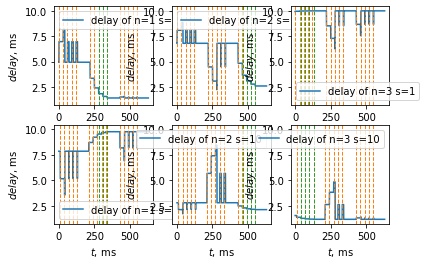

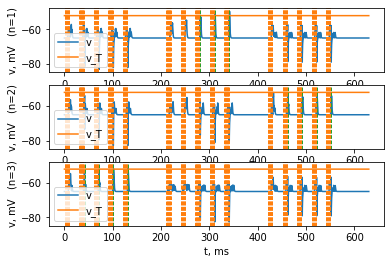

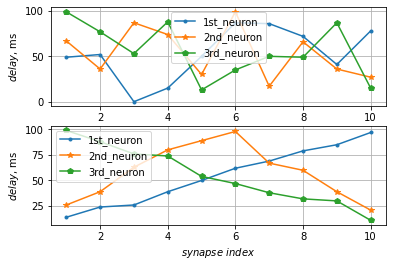

In [ ]:
def show_plots(e_state_mon, s_state_mon, i_spike_mon, e_spike_mon, ind_input, init_shifts, final_shifts):

    # plot the evolution of shifts
    plt.figure()
    NS = min(len(ind_input), 4) 
    for n in range(nn):
        for s in range(NS):
            sp_cell = NS * 100 + nn * 10 + s * nn + n + 1 # subplot coordinate
            if (n==0 and s==0): sp0 = plt.subplot(sp_cell) # make equal scales
            else: plt.subplot(sp_cell, sharex=sp0, sharey=sp0)
            plt.plot(s_state_mon.t/b2.ms, (s_state_mon.shift[ind_input[s] * nn + n] + s_state_mon.shift_correction[ind_input[s] * nn + n]) / b2.ms , label=f'delay of n={n+1} s={ind_input[s]+1}')
            for t in i_spike_mon.spike_trains()[ind_input[s]]:
                plt.axvline(t/b2.ms, ls='--', c='C1', lw=1) # orange == input
            for t in e_spike_mon.spike_trains()[n]:
                plt.axvline(t/b2.ms, ls='--', c='C2', lw=1) # green == main
            plt.legend()
            plt.xlabel("$t$, ms")
            plt.ylabel("$delay$, ms")

    # plot the evolution of membrane potential 
    plt.figure()
    for n in range(nn):
        if (n==0): sp1 = plt.subplot(nn*100 + 10*1 + n + 1) # make equal scales
        else: plt.subplot(nn*100 + 10*1 + n + 1, sharex=sp1, sharey=sp1)
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.v[n]/b2.mV, label='v')
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.vt_n[n]/b2.mV , label='v_T')
        #plt.plot(e_state_mon.t/b2.ms, e_state_mon.g_n[n] , label='g_n')
        for t in i_spike_mon.t:
            plt.axvline(t/b2.ms, ls='--', c='C1', lw=1) # orange == input
        for t in e_spike_mon.spike_trains()[n]:
            plt.axvline(t/b2.ms, ls='--', c='C2', lw=1) # green == main
        plt.legend()
        plt.xlabel("t, ms")
        plt.ylabel(f"v, mV   (n={n+1})")

    # plot initial and final shifts
    plt.figure()
    plt.subplot(2,1,1)
    # for i in range(nn):
    #     plt.plot(np.arange(1,ni + 1,1), init_shifts[i], marker = '*', label = f'{i}_neuron')
    plt.plot(np.arange(1,ni + 1,1), init_shifts[0], marker = '.', label = f'{1}st_neuron', linestyle = '-')
    plt.plot(np.arange(1,ni + 1,1), init_shifts[1], marker = '*', label = f'{2}nd_neuron', linestyle = '-')
    plt.plot(np.arange(1,ni + 1,1), init_shifts[2], marker = 'p', label = f'{3}rd_neuron', linestyle = '-')
    plt.legend()
    plt.xlabel("$synapse\ index$")
    plt.ylabel("$delay$, ms")
    #plt.title("Initial shifts values")
    plt.grid()
    plt.subplot(2,1,2)
    # for i in range(nn):
    #     plt.plot(np.arange(1,ni + 1,1), final_shifts[i], marker = '*', label = f'{i}_neuron')
    plt.plot(np.arange(1,ni + 1,1), final_shifts[0], marker = '.', label = f'{1}st_neuron', linestyle = '-')
    plt.plot(np.arange(1,ni + 1,1), final_shifts[1], marker = '*', label = f'{2}nd_neuron', linestyle = '-')
    plt.plot(np.arange(1,ni + 1,1), final_shifts[2], marker = 'p', label = f'{3}rd_neuron', linestyle = '-')
    plt.legend()
    plt.xlabel("$synapse\ index$")
    plt.ylabel("$delay$, ms")
    #plt.title("Final shifts values")
    plt.grid()



(train_left_spike_time, train_right_spike_time, train_central_spike_time) = DataImport(True)

if os.path.exists(file_path_initial_shifts):
    with open(file_path_initial_shifts, 'rb') as f:
        shifts = np.load(f) * b2.second
else:
    shifts = b2.rand(ni*nn) * max_spike_time * b2.ms
    np.save(file_path_initial_shifts, shifts)

snn = SNN(nn, ni, 1, shifts)

e_state_mon = b2.StateMonitor(snn.group_n, ['v', 'vt_n', 'g_n'], record=True)
s_state_mon = b2.StateMonitor(snn.synapses_e, ['shift', 'shift_correction'], record=True)
i_spike_mon = b2.SpikeMonitor(snn.input_group)
e_spike_mon = b2.SpikeMonitor(snn.group_n)
snn.net.add(e_state_mon)
snn.net.add(s_state_mon)
snn.net.add(i_spike_mon)
snn.net.add(e_spike_mon)

num = 1
for i in range(num):
    snn.input_group.set_spikes(list(range(ni)), train_left_spike_time[i] * b2.ms, train_period)
    snn.net.run(time_run * b2.ms)
    snn.input_group.set_spikes(list(range(ni)), [30000]*ni * b2.ms, 0 * b2.ms)
    snn.net.run(time_relax * b2.ms)

    snn.input_group.set_spikes(list(range(ni)), train_right_spike_time[i] * b2.ms, train_period)
    snn.net.run(time_run * b2.ms)
    snn.input_group.set_spikes(list(range(ni)), [30000]*ni * b2.ms, 0 * b2.ms)
    snn.net.run(time_relax * b2.ms)

    snn.input_group.set_spikes(list(range(ni)), train_central_spike_time[i] * b2.ms, train_period)
    snn.net.run(time_run * b2.ms)
    snn.input_group.set_spikes(list(range(ni)), [30000]*ni * b2.ms, 0 * b2.ms)
    snn.net.run(time_relax * b2.ms)


np.save(file_path_shifts, snn.synapses_e.shift)

init_shifts = (shifts/b2.ms*10//1).reshape(ni, nn).transpose()
print("Init shifts:")
print(init_shifts)
final_shifts = (snn.synapses_e.shift/b2.ms*10//1).reshape(ni, nn).transpose()
print("Final shifts:")
print(final_shifts)

ind_input_to_show = [0,9]
show_plots(e_state_mon, s_state_mon, i_spike_mon, e_spike_mon, ind_input_to_show, init_shifts, final_shifts)

snn.net.remove(e_state_mon)
snn.net.remove(s_state_mon)
snn.net.remove(i_spike_mon)
snn.net.remove(e_spike_mon)


In [ ]:
def test(snn, times_sample):
    test_mon = SpikeMonitor(snn.group_n)
    snn.net.add(test_mon)
    snn.input_group.set_spikes(list(range(ni)), times_sample * b2.ms, train_period)
    snn.net.run(time_run * b2.ms)
    snn.input_group.set_spikes(list(range(ni)), [30000]*ni * b2.ms, 0 * b2.ms)
    snn.net.run(time_relax * b2.ms)
    snn.net.remove(test_mon)
    return test_mon.count

def CreateClasses(snn):
    (train_left_spike_time, train_right_spike_time, train_central_spike_time) = DataImport(True)

    spike_num_left = np.zeros([nn])
    spike_num_right = np.zeros([nn])
    spike_num_central = np.zeros([nn])
    for i in range(4):
        ind = 0 # or i
        count = test(snn, train_left_spike_time[ind])
        spike_num_left += np.asarray(count)
        count = test(snn, train_right_spike_time[ind])
        spike_num_right += np.asarray(count)
        count = test(snn, train_central_spike_time[ind])
        spike_num_central += np.asarray(count)

    classes = {}
    classes[spike_num_left.argmax()] = "left"
    classes[spike_num_right.argmax()] = "right"
    classes[spike_num_central.argmax()] = "central"

    print(classes)
    print(spike_num_left, spike_num_right, spike_num_central)

    return classes

WARNING    'i' is an internal variable of group 'synapses_4', but also exists in the run namespace with the value 7. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 210. ms), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 0.42 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 0.63 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 0.84 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WA

{2: 'left', 0: 'right', 1: 'central'}
[ 0.  0. 20.] [20.  0.  0.] [ 0. 20.  0.]


WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 2.73 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 2.94 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 3.15 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 3.36 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 3.57 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The 

----------------------EXPERIMENT 1---------------------------
Mean test time:
[1. 1. 3. 4. 5. 6. 7. 7. 9. 9.]
[9. 8. 8. 7. 6. 5. 4. 2. 2. 1.]
[9. 7. 6. 4. 2. 2. 4. 5. 8. 9.]
Precision:  1.0
Recall:  1.0
F1_score:  1.0


WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 9.03 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 9.24 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 9.45 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 9.66 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 9.87 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The 

----------------------EXPERIMENT 2---------------------------
Mean test time:
[1. 2. 3. 4. 5. 5. 6. 7. 8. 9.]
[9. 8. 7. 6. 6. 5. 4. 3. 2. 1.]
[9. 7. 6. 4. 2. 2. 4. 5. 7. 9.]
Precision:  1.0
Recall:  1.0
F1_score:  1.0


WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 15.33 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 15.54 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 15.75 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 15.96 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 16.17 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING   

----------------------EXPERIMENT 3---------------------------
Mean test time:
[1. 2. 3. 4. 5. 5. 6. 7. 8. 9.]
[9. 8. 7. 6. 5. 5. 4. 3. 2. 1.]
[9. 7. 6. 4. 2. 2. 4. 5. 7. 9.]
Precision:  1.0
Recall:  1.0
F1_score:  1.0


WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 21.63 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 21.84 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 22.05 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 22.26 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 22.47 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING   

----------------------EXPERIMENT 4---------------------------
Mean test time:
[2. 2. 3. 4. 5. 5. 6. 7. 8. 8.]
[8. 8. 7. 6. 5. 5. 4. 3. 2. 2.]
[8. 7. 6. 4. 3. 3. 4. 5. 7. 8.]
Precision:  0.8
Recall:  0.8
F1_score:  0.8000000000000002


WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 27.93 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 28.14 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 28.35 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 28.56 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 28.77 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING   

----------------------EXPERIMENT 5---------------------------
Mean test time:
[2. 3. 3. 4. 5. 5. 6. 7. 7. 8.]
[8. 7. 7. 6. 5. 5. 4. 3. 3. 2.]
[8. 7. 6. 4. 3. 3. 4. 5. 7. 8.]
Precision:  0.5333333333333333
Recall:  0.5333333333333333
F1_score:  0.5333333333333333


WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 34.17 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 34.23 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 34.38 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 34.44 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 34.59 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING   

----------------------EXPERIMENT 6---------------------------
Mean test time:
[2. 3. 4. 4. 5. 5. 6. 6. 7. 8.]
[8. 7. 6. 6. 5. 5. 4. 4. 3. 2.]
[8. 7. 6. 4. 3. 3. 4. 5. 7. 8.]
Precision:  0.5
Recall:  0.5
F1_score:  0.5


WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 40.47 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 40.53 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 40.68 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 40.74 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 40.89 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING   

----------------------EXPERIMENT 7---------------------------
Mean test time:
[3. 3. 4. 4. 5. 5. 6. 6. 7. 7.]
[7. 7. 6. 6. 5. 5. 4. 4. 3. 3.]
[8. 7. 6. 4. 3. 3. 4. 5. 7. 8.]
Precision:  0.3333333333333333
Recall:  0.3333333333333333
F1_score:  0.3333333333333333


WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 46.77 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 46.83 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 46.98 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 47.04 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 47.19 s), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING   

----------------------EXPERIMENT 8---------------------------
Mean test time:
[3. 3. 4. 4. 5. 5. 6. 6. 7. 7.]
[7. 7. 6. 6. 5. 5. 4. 4. 3. 3.]
[7. 6. 6. 5. 4. 4. 5. 5. 6. 7.]
Precision:  0.3333333333333333
Recall:  0.3333333333333333
F1_score:  0.3333333333333333


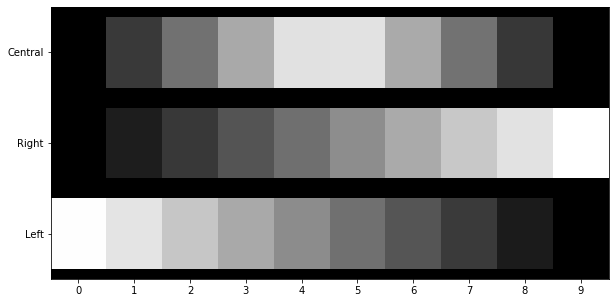

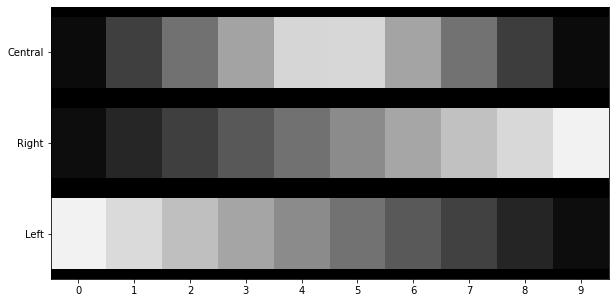

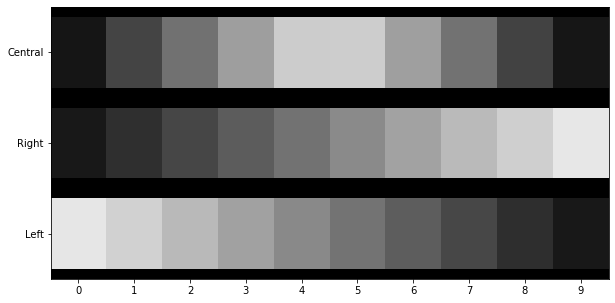

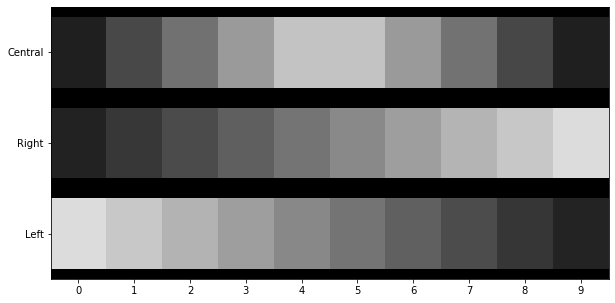

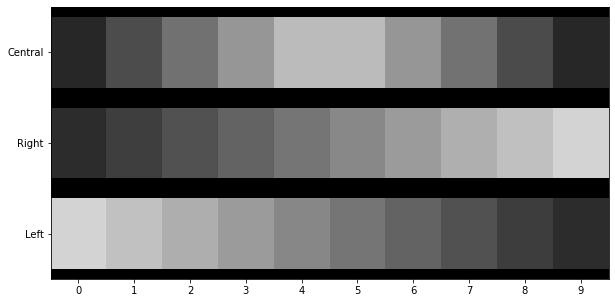

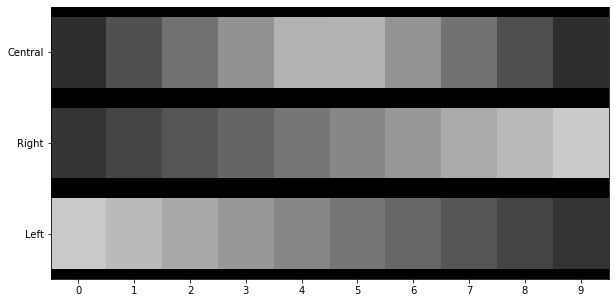

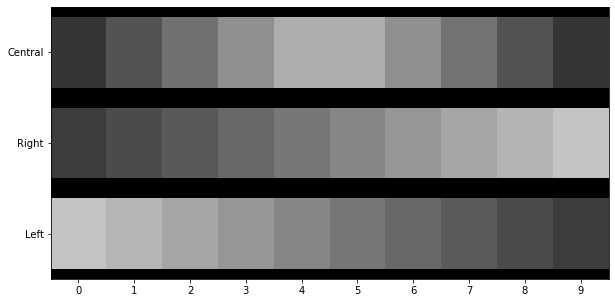

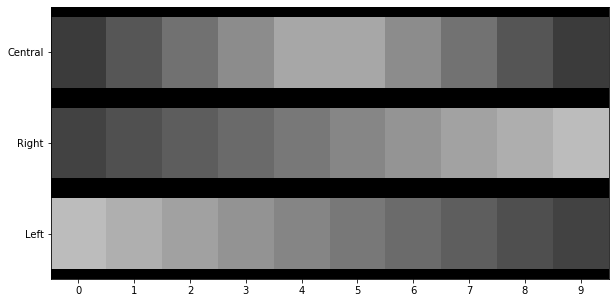

In [ ]:
def show_confusion_matrix(pred, labels):
    data = {'y_Actual': labels, 'y_Predicted': pred}
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(confusion_matrix, annot=True)

def analyse(pred, labels):
    precision = accuracy_score(labels, pred)
    recall = recall_score(labels, pred, average='micro')
    F1_score = f1_score(labels, pred, average='micro')
    return precision, recall, F1_score 

def intensity(time):
    intensity_norm = (max_spike_time - time) / (max_spike_time - min_spike_time)
    intensity_scaled = (max_intensity - min_intensity) * intensity_norm + min_intensity
    return intensity_scaled

def draw_intensity(intensity_samples, minI, maxI):
    x = np.arange(-0.5, ni, 1)
    y = np.arange(-0.5, 3, 1)
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_xticks(range(ni))
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(["Left", "Right", "Central"])
    ax.pcolormesh(x, y, intensity_samples, cmap='gray', vmin=minI, vmax=maxI)
    #for k in x:
      #plt.axvline(k, ls='-', c='w', lw=4) # white line between bars
    for k in y:
      plt.axhline(k, ls='-', c='black', lw=20)

def predict(snn, test_times, classes):
    pred = []
    for times_sample in test_times:
        spike_num = np.asarray(test(snn, times_sample))
        pred += [classes[spike_num.argmax()]]
    return pred

def increase_noise(current_test_times, coef):
    for k in range(n_test):
        noise = np.random.randn(ni) * coef
        times_sample = current_test_times[k]
        new_times_sample = np.clip(times_sample + noise, min_spike_time, max_spike_time)
        current_test_times[k] = new_times_sample

def decrease_contrast(current_test_times, coef):
    for k in range(n_test):
        times_sample = current_test_times[k]
        new_times_sample = coef*times_sample + (1-coef)*sum(times_sample)/ni
        current_test_times[k] = new_times_sample

def plot_F1_score_change(f1):
    #axes_x = np.array([20*math.log10(256*(0.7**i)/10) for i in range(len(f1))])
    axes_x = np.linspace(1, len(f1), len(f1))
    plt.plot(axes_x, f1, marker = '*')
    #plt.xlabel("signal / noise, Db")
    plt.xlabel("The iteration of experiment")
    plt.ylabel("F1-score value")
    #plt.title("F1-score curve")
    plt.grid()


(test_left_spike_times, test_right_spike_times, test_central_spike_times) = DataImport(False)

with open(file_path_shifts, 'rb') as f:
    shifts = np.load(f) * b2.second
snn = SNN(nn, ni, 0, shifts)

classes = CreateClasses(snn)

test_times = np.hstack([test_left_spike_times, test_right_spike_times, test_central_spike_times]).reshape(n_test, ni)
labels = ["left", "right", "central"]*(n_test//3)
acc_f1 = []

for i in range(8):
    mean_test_time_left = np.mean(test_times[0:n_test-2:3], axis = 0)
    mean_test_time_right = np.mean(test_times[1:n_test-1:3], axis = 0)
    mean_test_time_central = np.mean(test_times[2:n_test:3], axis = 0)
    intensities = np.vstack((intensity(mean_test_time_left), intensity(mean_test_time_right), intensity(mean_test_time_central)))
    draw_intensity(intensities, min_intensity, max_intensity)

    pred = predict(snn, test_times, classes)
    #show_confusion_matrix(pred, labels)
    precision, recall, F1_score = analyse(pred, labels)
    acc_f1.append(F1_score)

    print(f"----------------------EXPERIMENT {i+1}---------------------------")
    print("Mean test time:")
    print(mean_test_time_left//1)
    print(mean_test_time_right//1)
    print(mean_test_time_central//1)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1_score: ", F1_score) 
    #increase_noise(test_times, 1.5)
    decrease_contrast(test_times, 0.9)

#plot_F1_score_change(np.array(acc_f1))


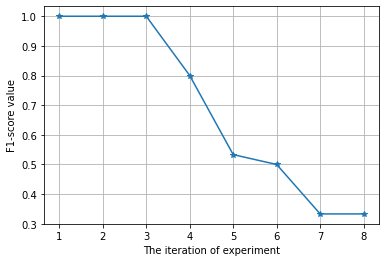

In [ ]:
def plot_F1_score_change(f1):
    #axes_x = np.array([20*math.log10(256*(0.7**i)/10) for i in range(len(f1))])
    axes_x = np.linspace(1, len(f1), len(f1))
    plt.plot(axes_x, f1, marker = '*')
    #plt.xlabel("signal / noise, Db")
    plt.xlabel("The iteration of experiment")
    plt.ylabel("F1-score value")
    #plt.title("F1-score curve")
    plt.grid()

plot_F1_score_change(np.array(acc_f1))
